In [1]:
# use R to change path to ~/cdai/SpliFi/analysis if current working path is not

setwd("~/cdai/SpliFi/analysis")


In [2]:
suppressMessages(library(tidyverse))
suppressMessages(library(glue))
suppressMessages(library(data.table))
suppressMessages(library(cowplot))

In [3]:
theme_set(theme_cowplot())

In [4]:
options(repr.plot.width = 10, repr.plot.height=7, repr.plot.res = 180)

In [5]:
suppressMessages(library(furrr))
plan(multisession, workers = 6)

# Call sQTLs using separate unproductive introns

In [9]:
tallySQTL <- function(tissue) {

    chroms = glue('chr{1:22}')
    perm.fs  <- glue('/project2/yangili1/cdai/SpliFi/code/results/qtl/noisy/GTEx/{tissue}/separateNoise/cis_100000/perm/{chroms}.addQval.txt.gz')
    names(perm.fs) <- chroms
    perm.df  <- map_dfr(perm.fs, ~fread(.x)[, .(phenotype_id, pval_adj, q)])

    pid_split  <- str_split(perm.df$phenotype_id, ":", simplify = TRUE)
    perm.df[, `:=`(cluid = str_remove_all(pid_split[, 4], "_.$"),
                introntype = pid_split[, 5])]
    perm.df[, clutype := paste(unique(sort(introntype)), collapse = ","), by = .(cluid)]

    # number of introns (U vs. P)
    numIntrons <- perm.df[, .N, by = introntype]

    # number of qtls (U vs. P)
    numQTLs <- perm.df[q < 0.1 & clutype != "N"][, .(N = uniqueN(cluid)), by = .(clutype)]

    return(list(numIntrons = numIntrons, numQTLs = numQTLs))
}

In [10]:
tallySQTL('Lung')

Warning message in `[.data.table`(perm.df, , `:=`(cluid = str_remove_all(pid_split[, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


introntype,N
<chr>,<int>
N,25813
F,73047
clutype,N
<chr>,<int>
"F,N",3903
F,3454


In [11]:
tissues  <- dir('../code/results/pheno/noisy/GTEx/')
tissues  <- tissues[-which(tissues %in% c('Kidney-Medulla', 'Bladder'))]
length(tissues)
tissues



[1] 48

[1] "Adipose-Subcutaneous"                
 [2] "Adipose-Visceral_Omentum_"           
 [3] "AdrenalGland"                        
 [4] "Artery-Aorta"                        
 [5] "Artery-Coronary"                     
 [6] "Artery-Tibial"                       
 [7] "Brain-Amygdala"                      
 [8] "Brain-Anteriorcingulatecortex_BA24_" 
 [9] "Brain-Caudate_basalganglia_"         
[10] "Brain-CerebellarHemisphere"          
[11] "Brain-Cerebellum"                    
[12] "Brain-Cortex"                        
[13] "Brain-FrontalCortex_BA9_"            
[14] "Brain-Hippocampus"                   
[15] "Brain-Hypothalamus"                  
[16] "Brain-Nucleusaccumbens_basalganglia_"
[17] "Brain-Putamen_basalganglia_"         
[18] "Brain-Spinalcord_cervicalc-1_"       
[19] "Brain-Substantianigra"               
[20] "Breast-MammaryTissue"                
[21] "Cells-Culturedfibroblasts"           
[22] "Cells-EBV-transformedlymphocytes"    
[23] "Colon-Sigmoid"                       
[24] "Colon-Transverse"                    
[25] "Esophagus-GastroesophagealJunction"  
[26] "Esophagus-Mucosa"                    
[27] "Esophagus-Muscularis"                
[28] "Heart-AtrialAppendage"               
[29] "Heart-LeftVentricle"                 
[30] "Liver"                               
[31] "Lung"                                
[32] "MinorSalivaryGland"                  
[33] "Muscle-Skeletal"                     
[34] "Nerve-Tibial"                        
[35] "Ovary"                               
[36] "Pancreas"                            
[37] "Pituitary"                           
[38] "Prostate"                            
[39] "Skin-NotSunExposed_Suprapubic_"      
[40] "Skin-SunExposed_Lowerleg_"           
[41] "SmallIntestine-TerminalIleum"        
[42] "Spleen"                              
[43] "Stomach"                             
[44] "Testis"                              
[45] "Thyroid"                             
[46] "Uterus"                              
[47] "Vagina"                              
[48] "WholeBlood"

In [12]:
qtl_results_tissues  <- future_map(tissues, tallySQTL)

Warning message in `[.data.table`(perm.df, , `:=`(cluid = str_remove_all(pid_split[, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”
Warning message in `[.data.table`(perm.df, , `:=`(cluid = str_remove_all(pid_split[, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid nam

In [15]:
names(qtl_results_tissues) <- tissues

In [20]:
nIntrons  <- map(qtl_results_tissues, pluck, 'numIntrons') %>%
    imap_dfr(~.x[, tissue := .y][])

In [23]:
nIntrons[1:5]

introntype,N,tissue
<chr>,<int>,<chr>
N,24029,Adipose-Subcutaneous
F,68537,Adipose-Subcutaneous
N,24055,Adipose-Visceral_Omentum_
F,69338,Adipose-Visceral_Omentum_
N,21459,AdrenalGland


In [24]:
nQTLs  <- map(qtl_results_tissues, pluck, 'numQTLs') %>%
    imap_dfr(~.x[, tissue := .y][])

In [25]:
nQTLs[1:5]

clutype,N,tissue
<chr>,<int>,<chr>
"F,N",4125,Adipose-Subcutaneous
F,3725,Adipose-Subcutaneous
F,3052,Adipose-Visceral_Omentum_
"F,N",3472,Adipose-Visceral_Omentum_
"F,N",1947,AdrenalGland


## Plot number of introns by tissue

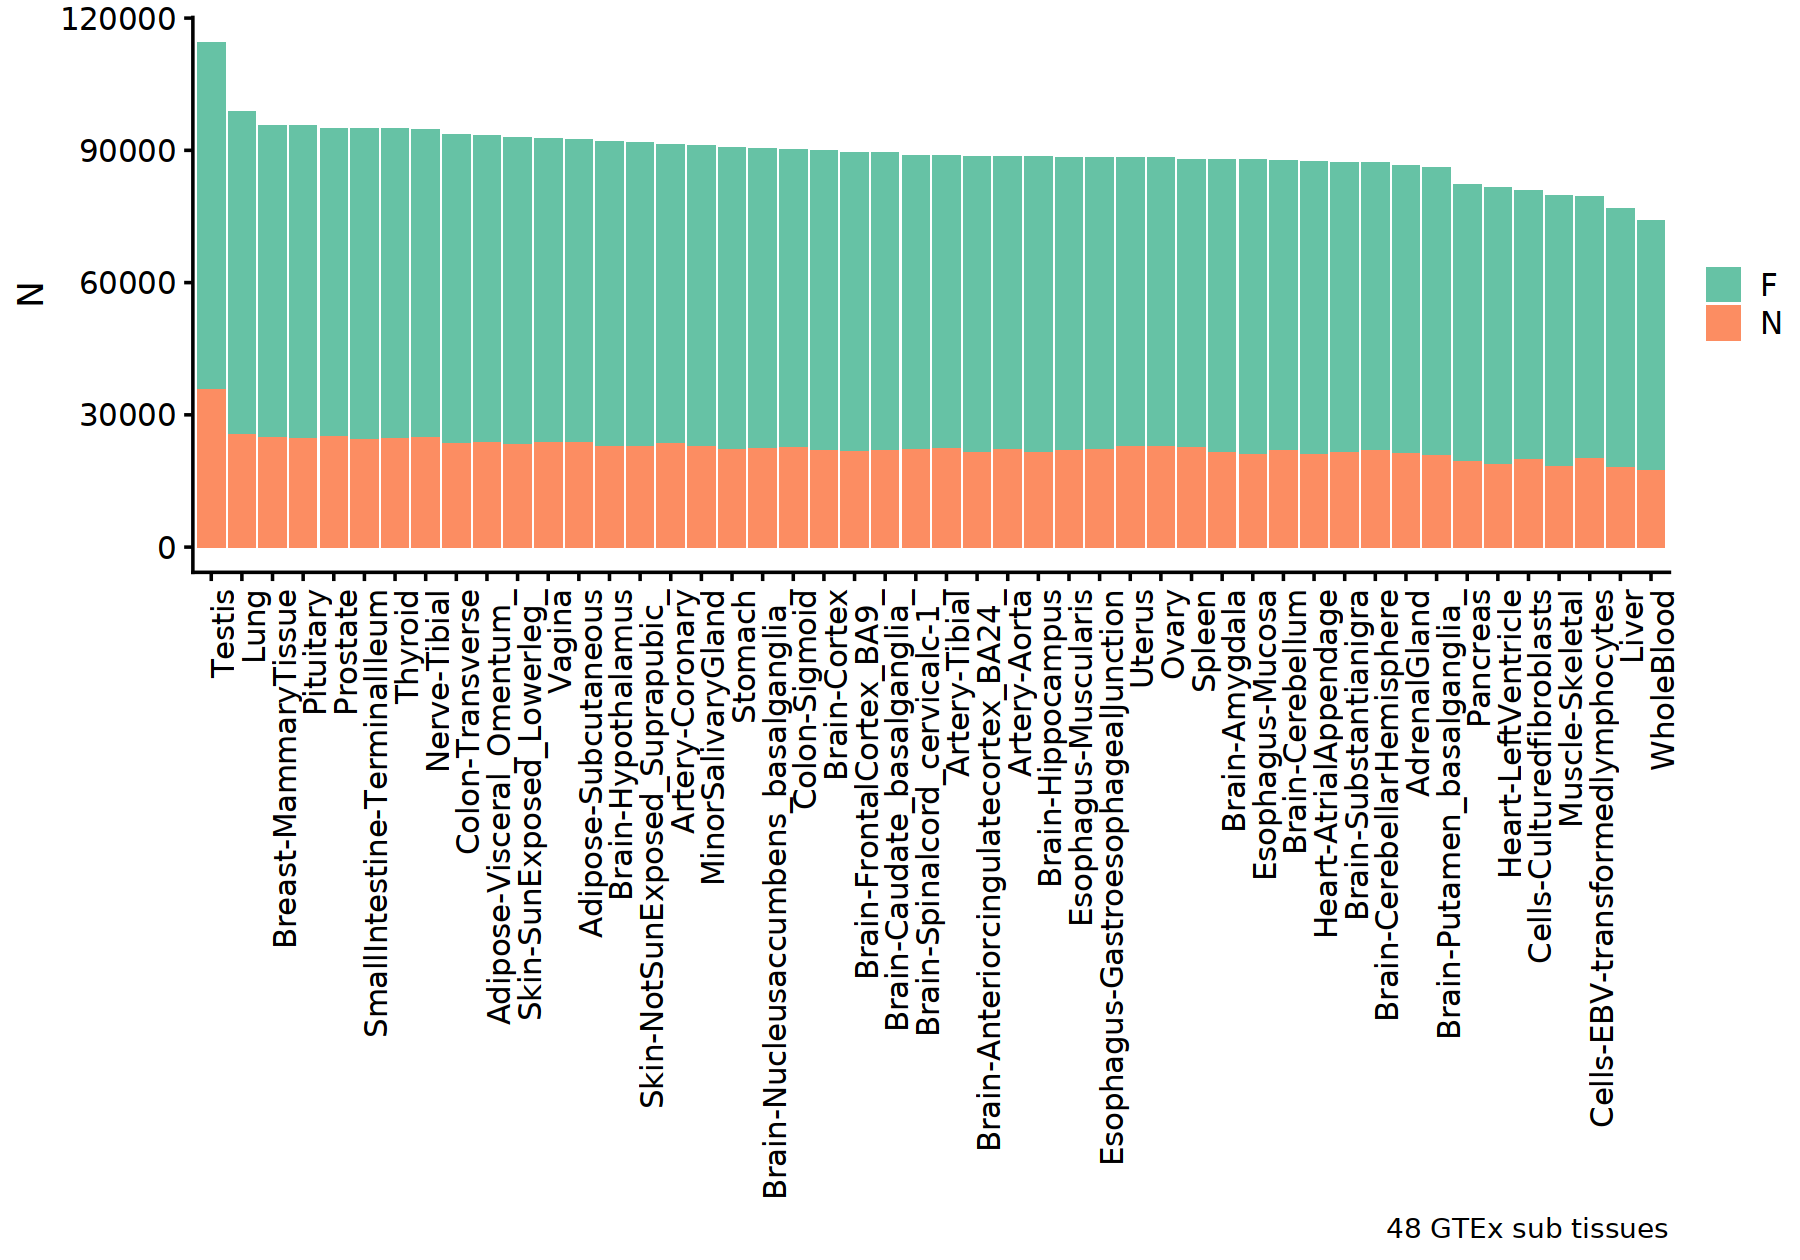

In [75]:
#| label: fig-number-of-introns
#| include: true

nIntrons %>% 
    ggplot() + geom_col(aes(x = forcats::fct_reorder(tissue, -N), y = N, fill = introntype)) +
        scale_fill_brewer(palette = 'Set2') +
        labs(fill = NULL, x = NULL, caption = "48 GTEx sub tissues") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [71]:
#| label: tbl-number-of-introns
#| include: true

nIntrons %>% 
    dcast(tissue ~ introntype, value.var = 'N') %>% 
    .[, .(tissue, F, N, Total = F + N)] %>% 
    .[order(-Total)]

tissue,F,N,Total
<chr>,<int>,<int>,<int>
Testis,78541,35886,114427
Lung,73047,25813,98860
Breast-MammaryTissue,70540,25182,95722
Pituitary,70754,24806,95560
Prostate,69782,25205,94987
SmallIntestine-TerminalIleum,70379,24537,94916
Thyroid,69952,24941,94893
Nerve-Tibial,69752,25017,94769
Colon-Transverse,69993,23688,93681


## Plot number of sQTLs

F: Productive introns

F,N: Unproductive introns

sQTLs are defined by intron clusters. 

- if all introns in a cluster are unproductive, the cluster is removed
- if all introns in a cluster are productive, the cluster is productive
- if a cluster contains both productive and unproductive introns, the cluster is unproductive

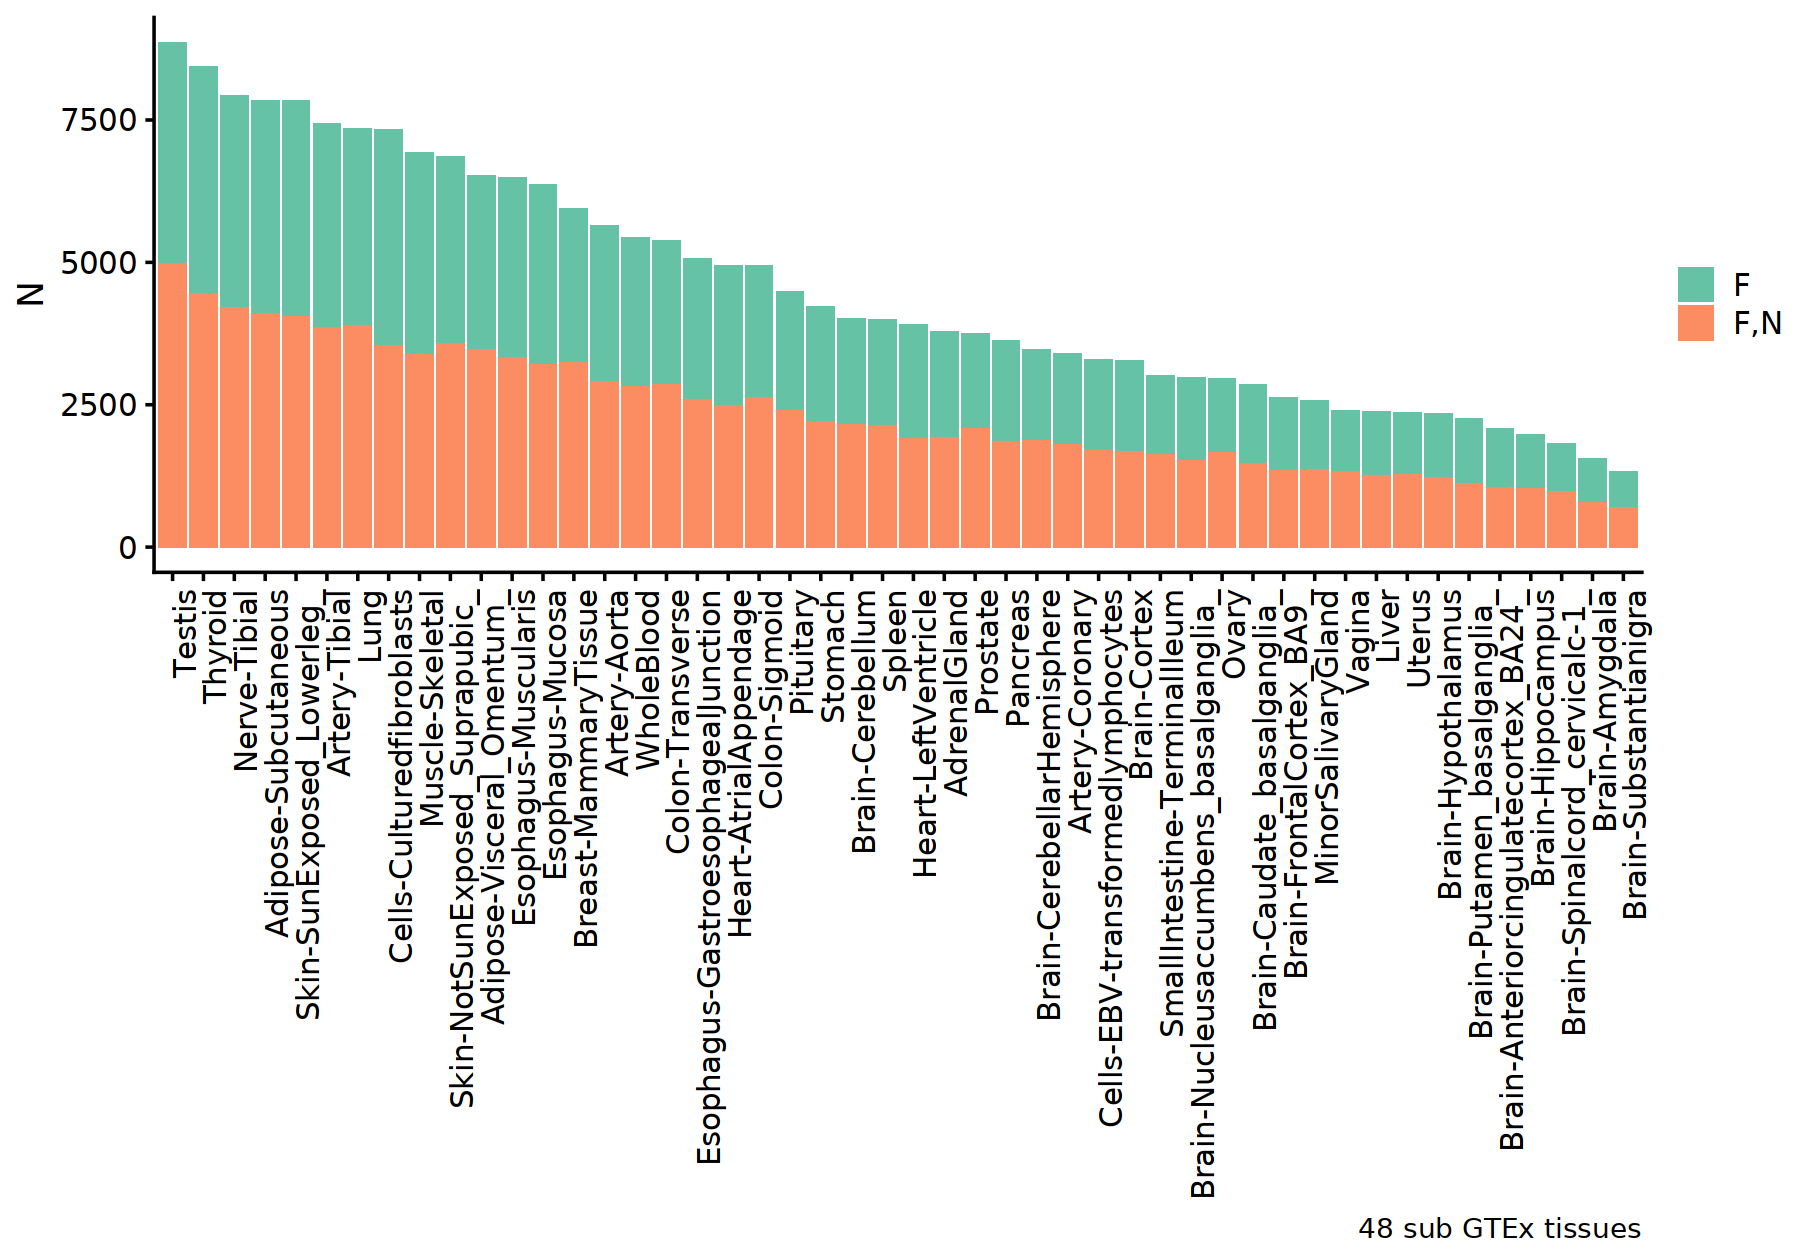

In [74]:
#| label: fig-number-of-sQTLs
#| include: true

nQTLs %>% 
    ggplot() + geom_col(aes(x = forcats::fct_reorder(tissue, -N), y = N, fill = clutype)) +
        scale_fill_brewer(palette = 'Set2') +
        labs(fill = NULL, x = NULL, caption = "48 sub GTEx tissues") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [72]:
#| label: tbl-number-of-sQTLs
#| include: true

nQTLs %>% 
    dcast(tissue ~ clutype, value.var = 'N') %>% 
    .[, .(tissue, U = `F,N`, P = F, Total = `F,N` + F)] %>% 
    .[order(-Total)]

tissue,U,P,Total
<chr>,<int>,<int>,<int>
Testis,4996,3862,8858
Thyroid,4469,3977,8446
Nerve-Tibial,4231,3701,7932
Adipose-Subcutaneous,4125,3725,7850
Skin-SunExposed_Lowerleg_,4065,3780,7845
Artery-Tibial,3876,3570,7446
Lung,3903,3454,7357
Cells-Culturedfibroblasts,3548,3785,7333
Muscle-Skeletal,3405,3527,6932


# Call sQLT using combined unproductive introns

In [7]:
tallySQTL2 <- function(tissue) {

    chroms = glue('chr{1:22}')
    perm.fs  <- glue('/project2/yangili1/cdai/SpliFi/code/results/qtl/noisy/GTEx/{tissue}/combineNoise/cis_100000/perm/{chroms}.addQval.txt.gz')
    names(perm.fs) <- chroms
    perm.df  <- map_dfr(perm.fs, ~fread(.x)[, .(phenotype_id, pval_adj, q)])

    pid_split  <- str_split(perm.df$phenotype_id, ":", simplify = TRUE)
    perm.df[, `:=`(cluid = str_remove_all(pid_split[, 4], "_[\\+\\-].*$"),
                introntype = if_else(str_detect(phenotype_id, "\\*"), "N", "F"))]
    perm.df[, clutype := paste(unique(sort(introntype)), collapse = ","), by = .(cluid)]

    # number of introns (U vs. P)
    numIntrons <- perm.df[, .N, by = introntype]

    # number of qtls (U vs. P)
    numQTLs <- perm.df[q < 0.1 & clutype != "N"][, .(N = uniqueN(cluid)), by = .(clutype)]

    return(list(numIntrons = numIntrons, numQTLs = numQTLs))
}

In [8]:
tallySQTL2('Lung')

Warning message in `[.data.table`(perm.df, , `:=`(cluid = str_remove_all(pid_split[, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


introntype,N
<chr>,<int>
F,29207
N,13411
clutype,N
<chr>,<int>
"F,N",3800
F,147


In [9]:
tissues  <- dir('../code/results/pheno/noisy/GTEx/')
tissues  <- tissues[-which(tissues %in% c('Kidney-Medulla', 'Bladder'))]
length(tissues)
tissues



[1] 48

[1] "Adipose-Subcutaneous"                
 [2] "Adipose-Visceral_Omentum_"           
 [3] "AdrenalGland"                        
 [4] "Artery-Aorta"                        
 [5] "Artery-Coronary"                     
 [6] "Artery-Tibial"                       
 [7] "Brain-Amygdala"                      
 [8] "Brain-Anteriorcingulatecortex_BA24_" 
 [9] "Brain-Caudate_basalganglia_"         
[10] "Brain-CerebellarHemisphere"          
[11] "Brain-Cerebellum"                    
[12] "Brain-Cortex"                        
[13] "Brain-FrontalCortex_BA9_"            
[14] "Brain-Hippocampus"                   
[15] "Brain-Hypothalamus"                  
[16] "Brain-Nucleusaccumbens_basalganglia_"
[17] "Brain-Putamen_basalganglia_"         
[18] "Brain-Spinalcord_cervicalc-1_"       
[19] "Brain-Substantianigra"               
[20] "Breast-MammaryTissue"                
[21] "Cells-Culturedfibroblasts"           
[22] "Cells-EBV-transformedlymphocytes"    
[23] "Colon-Sigmoid"                       
[24] "Colon-Transverse"                    
[25] "Esophagus-GastroesophagealJunction"  
[26] "Esophagus-Mucosa"                    
[27] "Esophagus-Muscularis"                
[28] "Heart-AtrialAppendage"               
[29] "Heart-LeftVentricle"                 
[30] "Liver"                               
[31] "Lung"                                
[32] "MinorSalivaryGland"                  
[33] "Muscle-Skeletal"                     
[34] "Nerve-Tibial"                        
[35] "Ovary"                               
[36] "Pancreas"                            
[37] "Pituitary"                           
[38] "Prostate"                            
[39] "Skin-NotSunExposed_Suprapubic_"      
[40] "Skin-SunExposed_Lowerleg_"           
[41] "SmallIntestine-TerminalIleum"        
[42] "Spleen"                              
[43] "Stomach"                             
[44] "Testis"                              
[45] "Thyroid"                             
[46] "Uterus"                              
[47] "Vagina"                              
[48] "WholeBlood"

In [10]:
qtl_results_tissues  <- future_map(tissues, tallySQTL2)

Warning message in `[.data.table`(perm.df, , `:=`(cluid = str_remove_all(pid_split[, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”
Warning message in `[.data.table`(perm.df, , `:=`(cluid = str_remove_all(pid_split[, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid nam

In [11]:
names(qtl_results_tissues) <- tissues

In [12]:
nIntrons  <- map(qtl_results_tissues, pluck, 'numIntrons') %>%
    imap_dfr(~.x[, tissue := .y][])

In [13]:
nIntrons[1:5]

introntype,N,tissue
<chr>,<int>,<chr>
F,27095,Adipose-Subcutaneous
N,12416,Adipose-Subcutaneous
F,27091,Adipose-Visceral_Omentum_
N,12488,Adipose-Visceral_Omentum_
F,23757,AdrenalGland


In [14]:
nQTLs  <- map(qtl_results_tissues, pluck, 'numQTLs') %>%
    imap_dfr(~.x[, tissue := .y][])

In [15]:
nQTLs[1:5]

clutype,N,tissue
<chr>,<int>,<chr>
"F,N",3999,Adipose-Subcutaneous
F,160,Adipose-Subcutaneous
"F,N",3371,Adipose-Visceral_Omentum_
F,136,Adipose-Visceral_Omentum_
"F,N",1912,AdrenalGland


## Plot number of introns by tissue

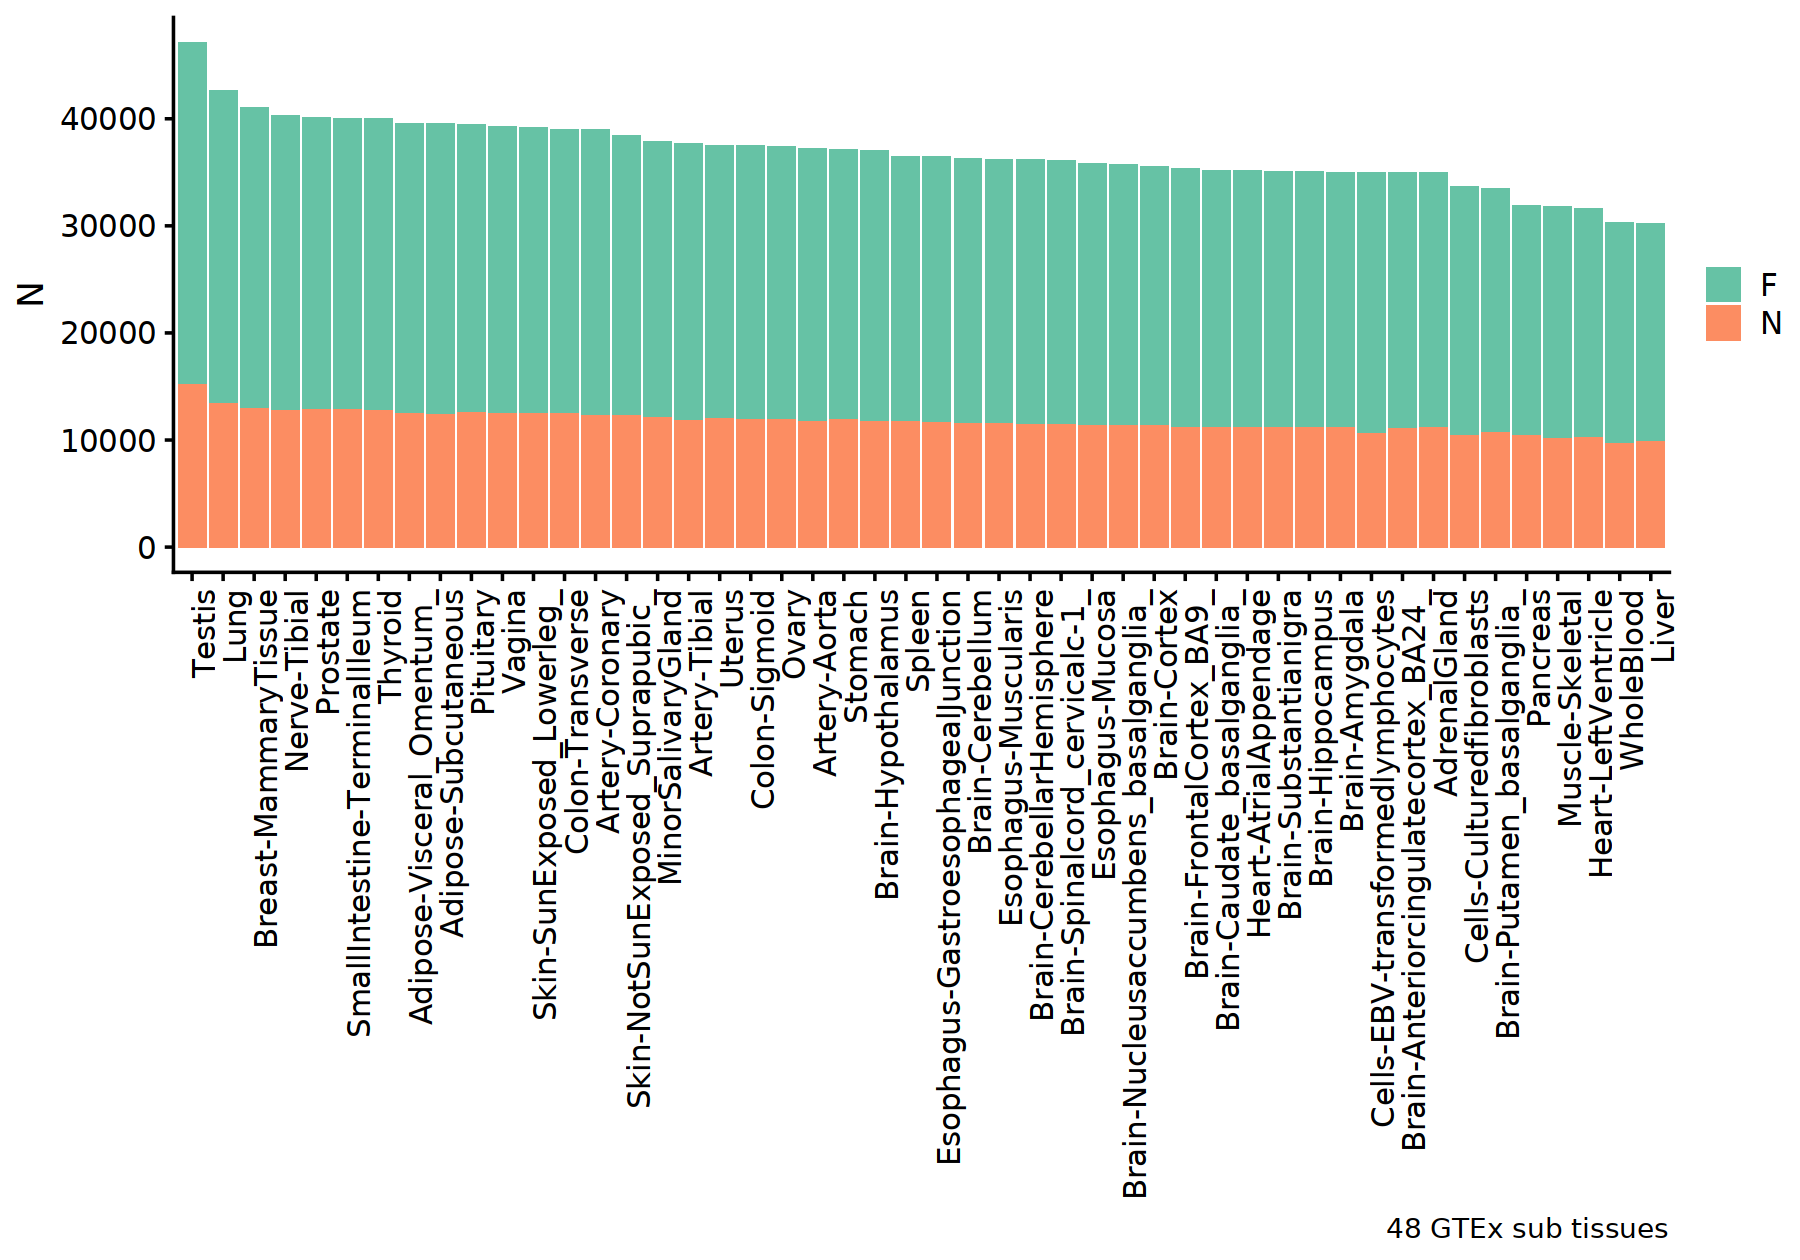

In [16]:
#| label: fig-number-of-introns-combineintrons
#| include: true

nIntrons %>% 
    ggplot() + geom_col(aes(x = forcats::fct_reorder(tissue, -N), y = N, fill = introntype)) +
        scale_fill_brewer(palette = 'Set2') +
        labs(fill = NULL, x = NULL, caption = "48 GTEx sub tissues") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [17]:
#| label: tbl-number-of-introns-combineintrons
#| include: true

nIntrons %>% 
    dcast(tissue ~ introntype, value.var = 'N') %>% 
    .[, .(tissue, F, N, Total = F + N)] %>% 
    .[order(-Total)]

tissue,F,N,Total
<chr>,<int>,<int>,<int>
Testis,31875,15230,47105
Lung,29207,13411,42618
Breast-MammaryTissue,28093,12969,41062
Nerve-Tibial,27526,12777,40303
Prostate,27262,12817,40079
SmallIntestine-TerminalIleum,27210,12826,40036
Thyroid,27213,12781,39994
Adipose-Visceral_Omentum_,27091,12488,39579
Adipose-Subcutaneous,27095,12416,39511


## Plot number of sQTLs

F: Productive introns

F,N: Unproductive introns

sQTLs are defined by intron clusters. 

- if all introns in a cluster are unproductive, the cluster is removed
- if all introns in a cluster are productive, the cluster is productive
- if a cluster contains both productive and unproductive introns, the cluster is unproductive

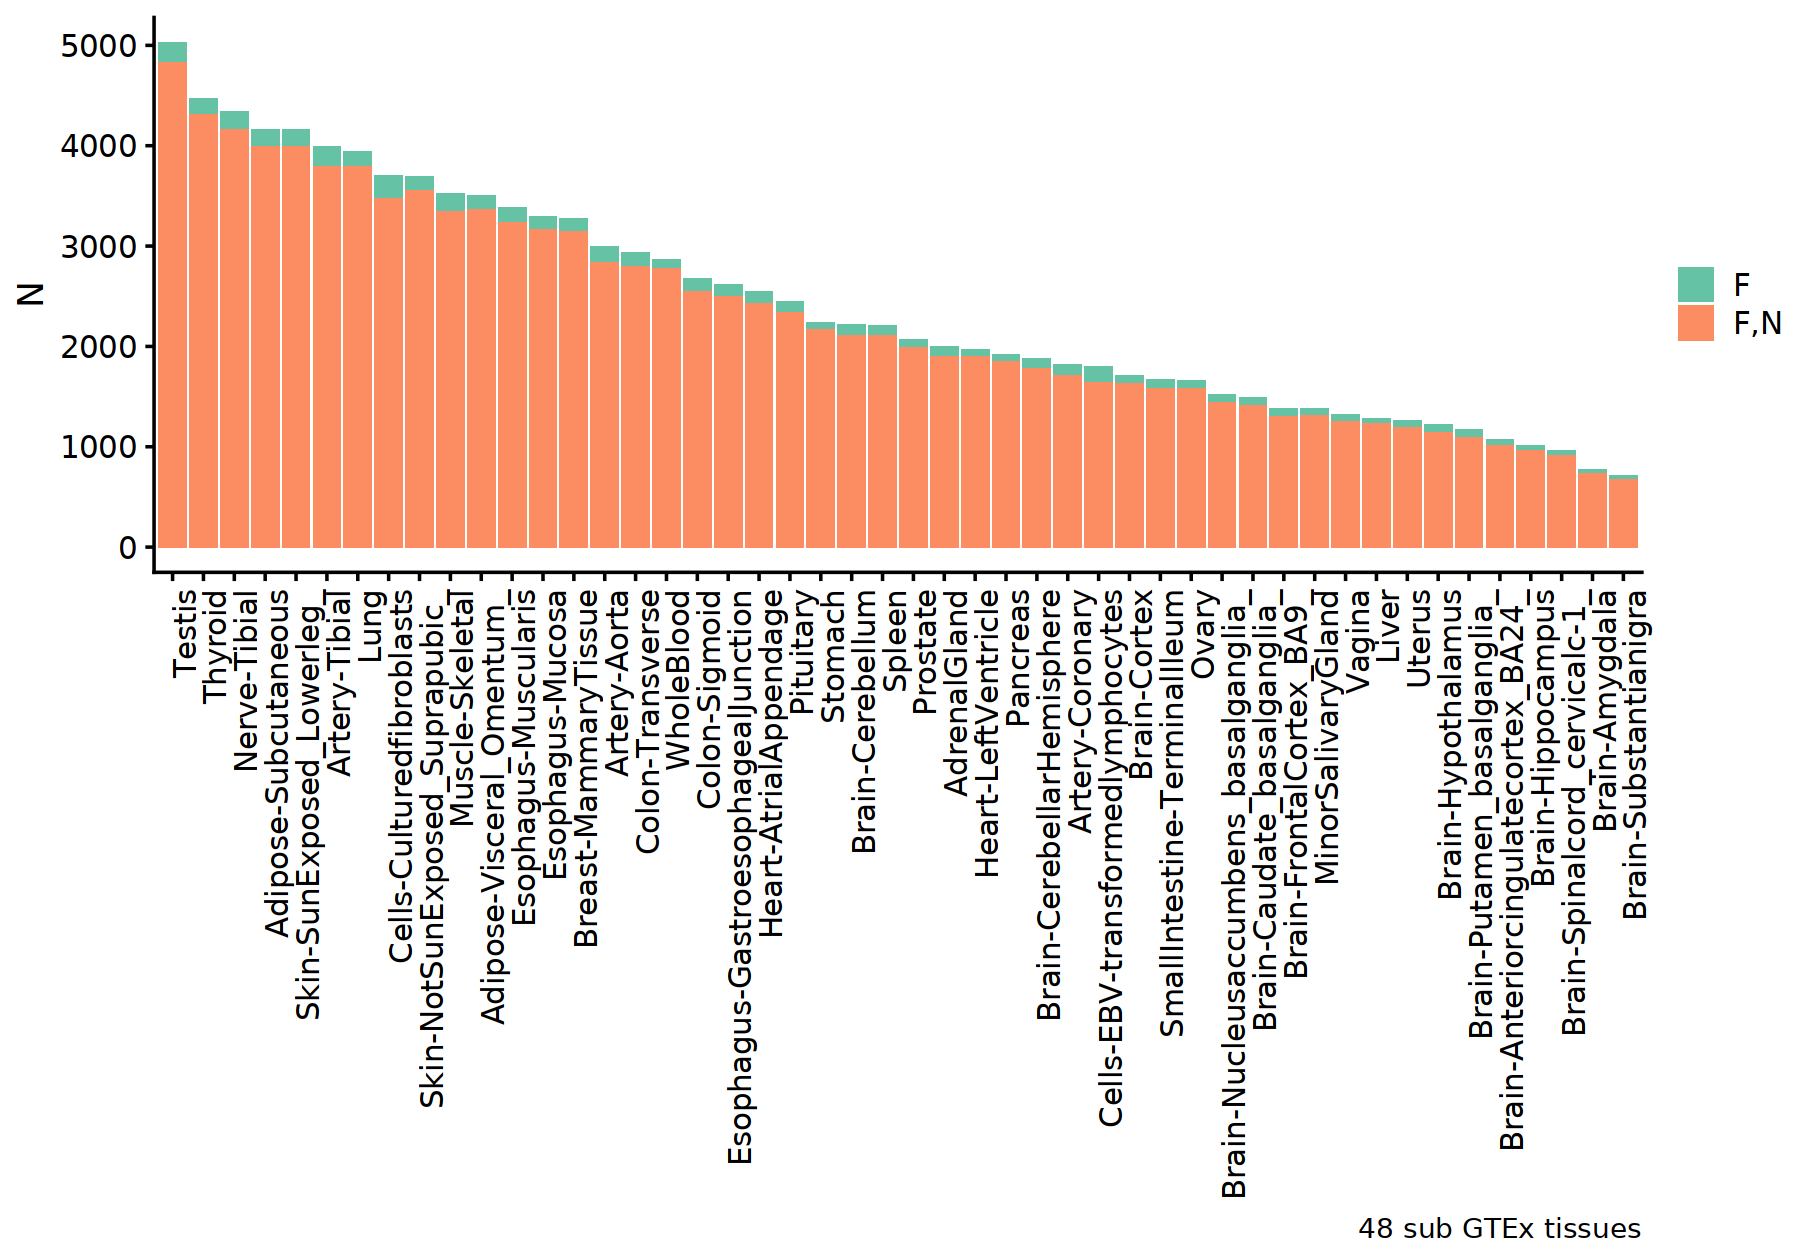

In [18]:
#| label: fig-number-of-sQTLs-combineintrons
#| include: true

nQTLs %>% 
    ggplot() + geom_col(aes(x = forcats::fct_reorder(tissue, -N), y = N, fill = clutype)) +
        scale_fill_brewer(palette = 'Set2') +
        labs(fill = NULL, x = NULL, caption = "48 sub GTEx tissues") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [19]:
#| label: tbl-number-of-sQTLs-combineintrons
#| include: true

nQTLs %>% 
    dcast(tissue ~ clutype, value.var = 'N') %>% 
    .[, .(tissue, U = `F,N`, P = F, Total = `F,N` + F)] %>% 
    .[order(-Total)]

tissue,U,P,Total
<chr>,<int>,<int>,<int>
Testis,4841,186,5027
Thyroid,4318,152,4470
Nerve-Tibial,4168,169,4337
Adipose-Subcutaneous,3999,160,4159
Skin-SunExposed_Lowerleg_,4003,154,4157
Artery-Tibial,3805,192,3997
Lung,3800,147,3947
Cells-Culturedfibroblasts,3484,224,3708
Skin-NotSunExposed_Suprapubic_,3561,136,3697
